In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit import BasicAer
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.opflow import I, X, Z, Y, StateFn
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import TwoLocal, NLocal
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.opflow.gradients import Gradient
from qiskit.circuit import ParameterVector
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/tmp/ipykernel_81152/2921901584.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import CompleteMeasFitter


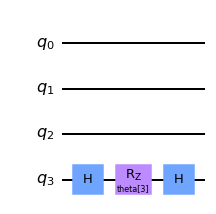

In [29]:
#Qui sotto ci sono diversi ansatz che ho usato, non mi andava di cancellarli


"""
#Ansatz1 è ottimo per risolvere H_anar con lambda = 0.2, maxiter di spsa è 550
ansatz = TwoLocal(num_qubits=4, 
                   rotation_blocks=["rz", "ry"], 
                   entanglement_blocks="cx",
                   entanglement='full',
                   reps=2,
                   insert_barriers=True)

def W(quantumcircuit, qubit1, qubit2, Theta):
    angolo = Theta/2
    PiDiviso2 = np.pi/2
    qc = quantumcircuit
    qc.cnot(qubit1, qubit2)
    qc.rx(angolo-PiDiviso2, qubit1)
    qc.h(qubit1)
    qc.rz(angolo, qubit2)
    qc.cnot(qubit1, qubit2)
    qc.h(qubit1)
    qc.rz(-angolo, qubit2)
    qc.cnot(qubit1, qubit2)
    qc.rx(PiDiviso2, qubit1)
    #applico la adjoint di rx
    qc.u3(PiDiviso2, PiDiviso2, -PiDiviso2, qubit2)

QC = QuantumCircuit(4)
"""
params = ParameterVector('theta', 6)
"""

for i in range(0,4):
    QC.x(i)
QC.h([0, 2])
QC.cnot(0,1)
QC.cnot(2,3)

#da valore che sembrano belli a primo acchitto
W(QC, 1, 2, params[0])
W(QC, 0, 3, params[1])
W(QC, 0, 1, params[2])
W(QC, 2, 3, params[3])

def egate (quantumcircuit, qubit1, qubit2, Theta):
    angolo = Theta/2
    PiDiviso2 = np.pi/2
    qc = quantumcircuit
    qc.cnot(qubit2, qubit1)
    qc.crx(Theta, qubit1, qubit2)
    qc.x(qubit1)
    qc.rz(-angolo, qubit1)
    qc.x(qubit1)
    qc.cnot(qubit2, qubit1)
QC.h(0)
QC.h(1)

egate(QC, 0, 2, params[0]) #Il primo fa da controllo, q_0, il seondo da target
egate(QC, 1, 3, params[1])
egate(QC, 0, 3, params[2])
egate(QC, 1, 2, params[3])
"""
"""
egate(QC, 0, 2, 2) #Il primo fa da controllo, q_0, il seondo da target
egate(QC, 1, 3, 3)
egate(QC, 0, 3, 4)
egate(QC, 1, 2, 5)

ansatz1 = NLocal(num_qubits=4, 
                rotation_blocks=QC,
                reps=1,
                insert_barriers=True)

print(QC)
ansatz3 = TwoLocal(num_qubits=4,
                   rotation_blocks=["rz"], 
                   entanglement_blocks="cx",
                   entanglement='linear',
                   reps=1,
                   insert_barriers=True)
"""
n = 4
qc = QuantumCircuit(n)

for i in range (3,n):
    qc.h(i)
    qc.rz(params[i],i)
    qc.h(i)
qc.draw()


#backend = BasicAer.get_backend('unitary_simulator')
#job = backend.run(transpile(qc, backend))
#job.result().get_unitary(qc, decimals=3)

In [3]:
#definisco una funzione che va a vedere tutti i termini intermedi della vqe, più precisamente i valori
#che l'ottimizzare classico trova
def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        parameter.append(parameters)
        standard.append(std)

#Questa è la matrice di una hamiltoniana anarmonica con s = 0.2 senza i termini con 10^(-16)
H_anar = (29.75 * I ^ I ^ I ^ I) + (-0.5 * I ^ I ^ I ^ Z) + (15.3757 * I ^I ^ X ^ I) + \
            (-0.150925 * I^I^X^Z) + \
            (-1.9 * I^I^Z^I) + (- 2.1 * I^I^Z^Z) + (3.99872 * I^X^I^I) + \
            (-0.400411 * I^X^I^Z) + (8.01247 * I^X^X^I) + \
            (-0.800007 * I^X^X^Z) + \
            (-0.800659 * I^X^Z^I) + \
            (0.0497082 * I^X^Z^Z) + \
            (8.01247 * I^Y^Y^I) + (-0.800007 * I^Y^Y^Z) +\
            (-7.7 * I^Z^I^I) + (-1.8 * I^Z^I^Z) + \
            (-4.95098 * I^Z^X^I) +(-1.0492 * I^Z^X^Z) + \
            (-2.7 * I^Z^Z^I) + (2.4 * I^Z^Z^Z) + (1.59979 * X^X^I^I) + \
            (-0.200028 * X^X^I^Z) + (3.20624 * X^X^X^I) + (-0.400001 * X^X^X^Z) + \
            (-0.400054 * X^X^Z^I) + \
            (0.0249895 * X^X^Z^Z) + \
            (-3.20624 * X^Y^Y^I) + \
            (0.400001 * X^Y^Y^Z) + \
            (3.20624 * Y^X^Y^I) + \
            (-0.400001 * Y^X^Y^Z) + (1.59979 *Y^Y^I^I) +(-0.200028 * Y^Y^I^Z) + \
            (3.20624 * Y^Y^X^I) + (-0.400001 * Y^Y^X^Z) + \
            (-0.400054 * Y^Y^Z^I) + \
            (0.0249895 * Y^Y^Z^Z) +(-19.3 * Z^I^I^I) + (-1.2 * Z^I^I^Z) + \
            (-11.351 * Z^I^X^I) + (-0.649199 * Z^I^X^Z) +\
            (-1.5 * Z^I^Z^I) + (2.4 * Z^I^Z^Z) + (-3.2011 * Z^X^I^I) + \
            (0.199604 * Z^X^I^Z) +(-6.40002 * Z^X^X^I) + (0.399994 * Z^X^X^Z) + \
            (0.399371 * Z^X^Z^I) + (-0.000287982 * Z^X^Z^Z) +\
            (-6.40002 * Z^Y^Y^I) + (0.399994 * Z^Y^Y^Z) + \
            (0.9 * Z^Z^I^I) + (2.4 * Z^Z^I^Z) + \
            (1.75075 * Z^Z^X^I) + (1.44908 * Z^Z^X^Z) + \
            (3.9 * Z^Z^Z^I) + (-2.4 * Z^Z^Z^Z)

In [30]:
#qui definisco il gradiente che poi utilizzerò nella vqe
expectation = StateFn(H_anar, is_measurement=True) @ StateFn(qc.decompose())
gradient = Gradient(grad_method='lin_comb').convert(expectation)
"""

#Mi assicuro che l'hamiltoniana sia giusta
Matrice = StateFn(H_anar).to_matrix_op()
print(Matrice)

"""
#Trovo il minimo autovalore dell'hamiltoniana, impongo questo metodo perchè quello sopra lo uso per vedere
#se quando trovo un valore enorme è perchè ha trovato un altro autovalore
npme = NumPyMinimumEigensolver()
result_classic = npme.compute_minimum_eigenvalue(operator=H_anar)
ref_value = result_classic.eigenvalue.real

In [31]:
backend = Aer.get_backend("qasm_simulator")

#backend = Aer.get_backend("aer_simulator_statevector")
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())

#trovo i valori minimi usando il vqe, tengo traccia del tempo necessario

quantum_instance = QuantumInstance(backend=backend, 
                                    shots= 2000,
                                    noise_model=noise_model, 
                                    coupling_map=coupling_map,
                                    measurement_error_mitigation_cls=CompleteMeasFitter)

/tmp/ipykernel_81152/3813723190.py:7: DeprecationWarning: Passing BackendProperties instead of a "backend" object has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date. Duration dependent delay relaxation noise requires a backend object.
  noise_model = NoiseModel.from_backend(device.properties())


In [32]:
start_time = time.time()
counts = []
values = []
parameter = []
standard = []
Minimo_vqe = []
vqe = VQE(qc, 
          optimizer = SPSA(maxiter=100),
          quantum_instance = quantum_instance,
          gradient=gradient,
          callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=H_anar)
circuit = vqe.expectation
Minimo_vqe.append(np.real(result.optimal_value))

#Printo il tempo impiegato
print("Sono stati impiegati %s secondi" % (time.time() - start_time))

#Printo i risultati ottenuti
print('Il risultato esatto è:', ref_value)
print("Il risultato del VQE è:", Minimo_vqe[0])
Errore = abs(Minimo_vqe[0] - ref_value)/ref_value * 100
print("L'errore relativo del", Errore, "%")

Sono stati impiegati 174.52835202217102 secondi
Il risultato esatto è: 0.6024137261891613
Il risultato del VQE è: 0.6300276873720045
L'errore relativo del 4.583886452509594 %


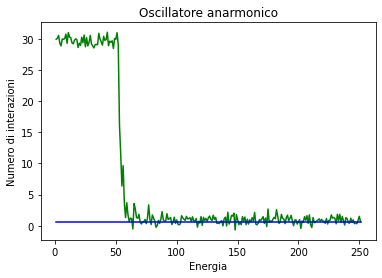

In [33]:
vero=[]
#plt.xlim(650, 700)
#plt.ylim(0,0.6)
plt.plot(counts, 
         values, 
         color="green", 
         linestyle="solid")
n = len(counts)
for i in range (0,n):
    vero.append(ref_value)
plt.plot(counts, 
         vero, 
         color="blue", 
         linestyle="solid")
plt.title("Oscillatore anarmonico")
plt.xlabel("Energia")
plt.ylabel("Numero di interazioni")
plt.show()
plt.close('all')


Caso 1
Sono stati impiegati 197.48780059814453 secondi
Il risultato del VQE è: 1.0711091445800012


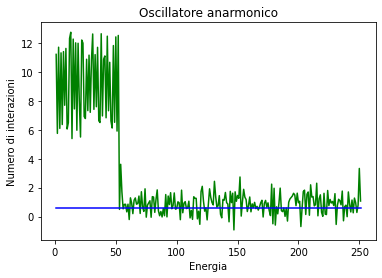

Caso 2
Sono stati impiegati 206.81563520431519 secondi
Il risultato del VQE è: 0.8243857340349949


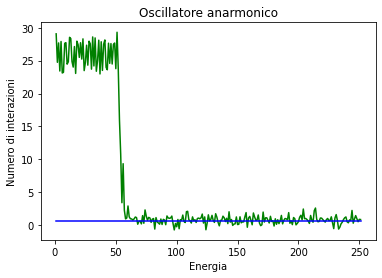

Caso 3
Sono stati impiegati 195.61895966529846 secondi
Il risultato del VQE è: 1.7459033176199983


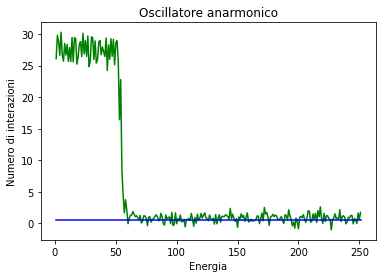

Caso 4
Sono stati impiegati 200.20646238327026 secondi
Il risultato del VQE è: -0.14260445669499655


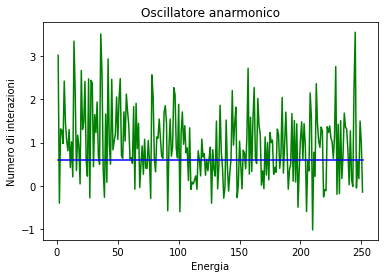

Caso 5
Sono stati impiegati 204.60166931152344 secondi
Il risultato del VQE è: 0.6916993107180086


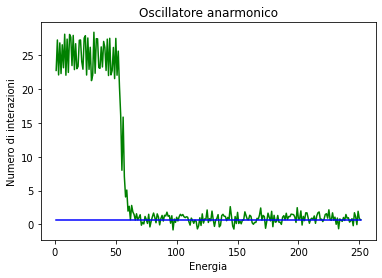

Caso 6
Sono stati impiegati 198.6952908039093 secondi
Il risultato del VQE è: 1.1709169888259963


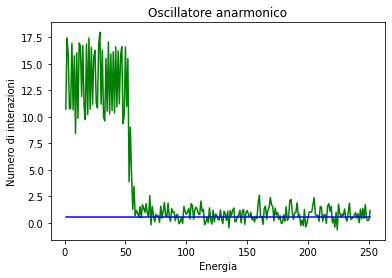

Caso 7
Sono stati impiegati 194.8767590522766 secondi
Il risultato del VQE è: 0.018570762831999835


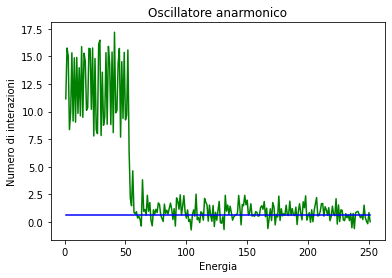

Caso 8
Sono stati impiegati 211.79194593429565 secondi
Il risultato del VQE è: 0.20024452698900003


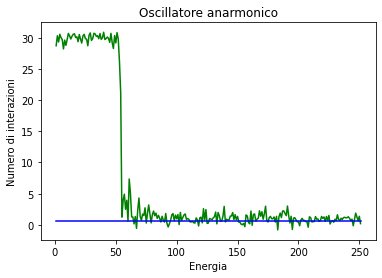

Caso 9
Sono stati impiegati 207.7044062614441 secondi
Il risultato del VQE è: -0.045451002744997554


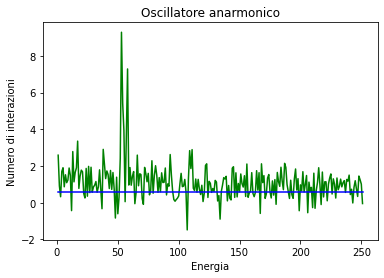

Caso 10
Sono stati impiegati 200.18524551391602 secondi
Il risultato del VQE è: 0.5050654883060054


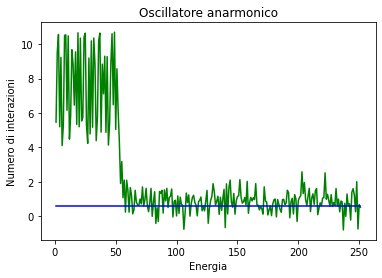

Caso 11
Sono stati impiegati 204.14056944847107 secondi
Il risultato del VQE è: 1.5075423732079956


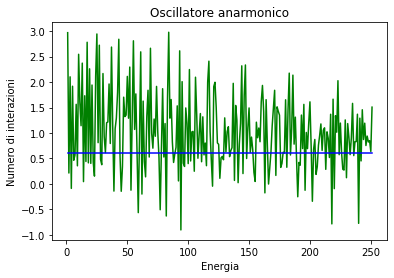

Caso 12
Sono stati impiegati 199.12987542152405 secondi
Il risultato del VQE è: 0.9709355991639982


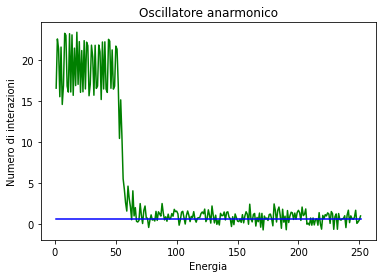

Caso 13
Sono stati impiegati 204.4816689491272 secondi
Il risultato del VQE è: 1.1554222032219965


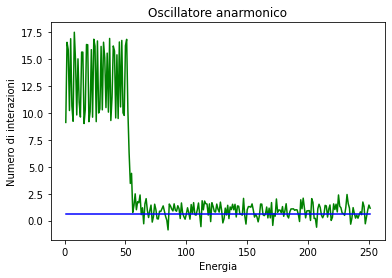

Caso 14
Sono stati impiegati 204.10916876792908 secondi
Il risultato del VQE è: 0.5152736921059954


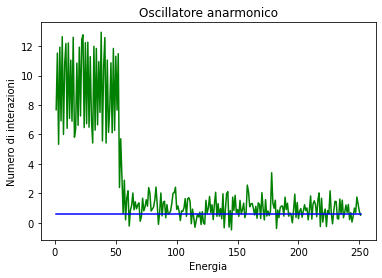

Caso 15
Sono stati impiegati 195.0012059211731 secondi
Il risultato del VQE è: 1.250006036877001


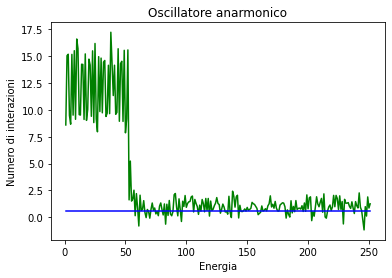

Caso 16
Sono stati impiegati 198.90543365478516 secondi
Il risultato del VQE è: -0.5088824409899957


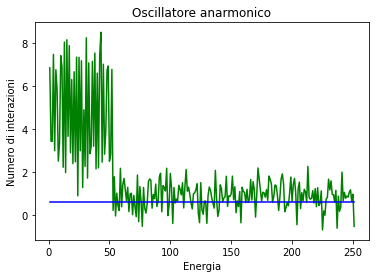

Caso 17
Sono stati impiegati 205.44808387756348 secondi
Il risultato del VQE è: -0.6091646898559985


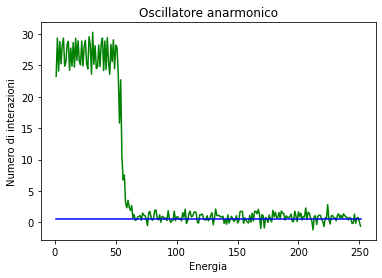

Caso 18
Sono stati impiegati 199.67825436592102 secondi
Il risultato del VQE è: -0.38859783133200065


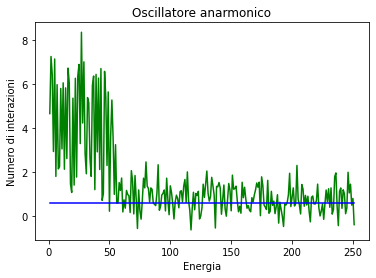

Caso 19
Sono stati impiegati 194.63298535346985 secondi
Il risultato del VQE è: 1.0396908373440046


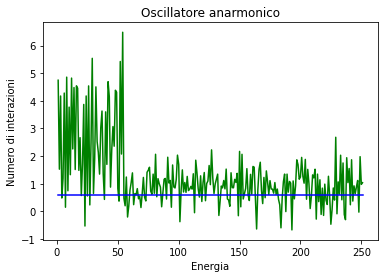

Caso 20
Sono stati impiegati 200.41162300109863 secondi
Il risultato del VQE è: 0.9128171595799974


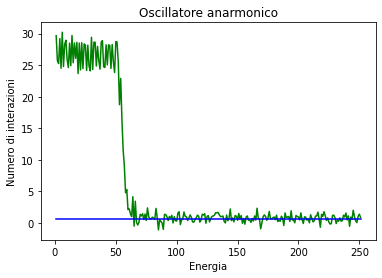

Caso 21
Sono stati impiegati 201.93065762519836 secondi
Il risultato del VQE è: 1.5120155897129999


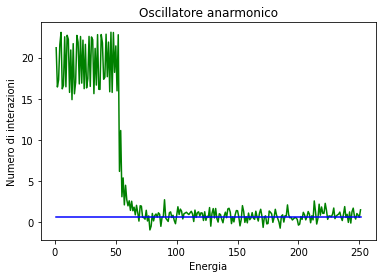

Caso 22
Sono stati impiegati 215.7883758544922 secondi
Il risultato del VQE è: 1.1122468525740001


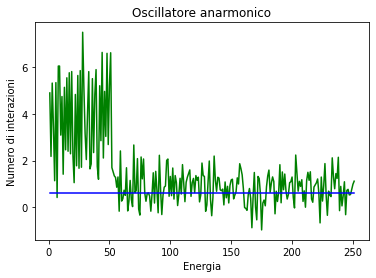

Caso 23
Sono stati impiegati 205.39776039123535 secondi
Il risultato del VQE è: 0.36584595406500026


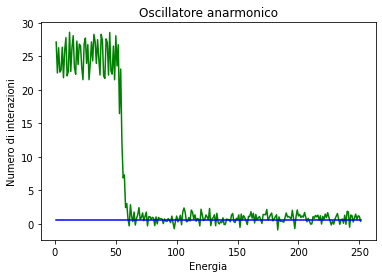

Caso 24
Sono stati impiegati 206.74681663513184 secondi
Il risultato del VQE è: 1.2805914765819981


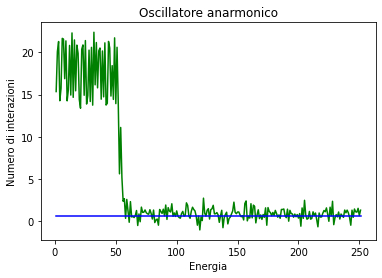

Caso 25
Sono stati impiegati 194.87651443481445 secondi
Il risultato del VQE è: 1.2008547040159971


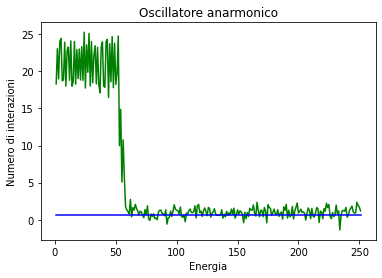

Caso 26
Sono stati impiegati 195.17212629318237 secondi
Il risultato del VQE è: 1.2100153392629984


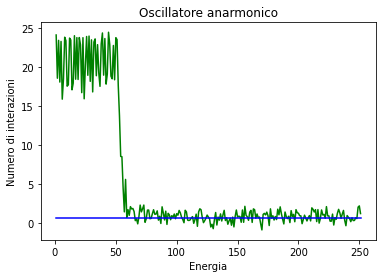

Caso 27
Sono stati impiegati 162.62284207344055 secondi
Il risultato del VQE è: 1.2184807441799996


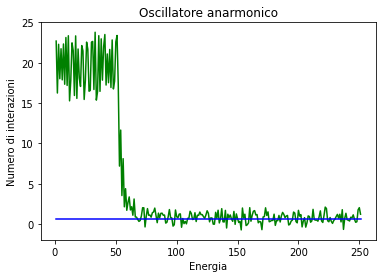

Caso 28
Sono stati impiegati 166.84222435951233 secondi
Il risultato del VQE è: 1.371270406093999


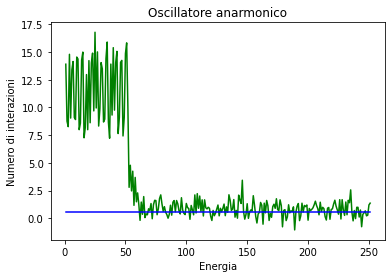

Caso 29
Sono stati impiegati 179.07197308540344 secondi
Il risultato del VQE è: 0.9966944556310002


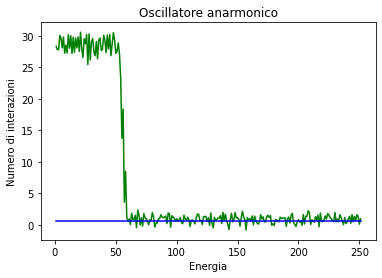

Caso 30
Sono stati impiegati 167.34426188468933 secondi
Il risultato del VQE è: 1.1473305455940022


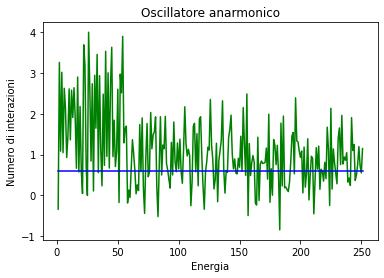

Caso 31
Sono stati impiegati 166.59741377830505 secondi
Il risultato del VQE è: 0.8095907598219984


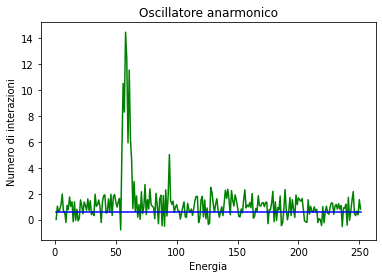

Caso 32
Sono stati impiegati 167.28071808815002 secondi
Il risultato del VQE è: 0.5804190509619932


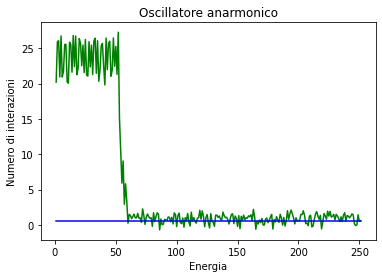

Caso 33
Sono stati impiegati 166.36767387390137 secondi
Il risultato del VQE è: 0.1898467725610067


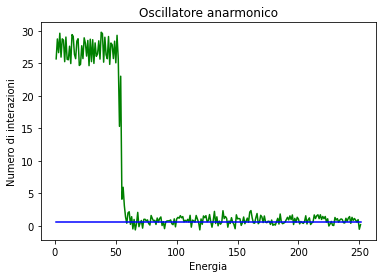

Caso 34
Sono stati impiegati 165.7908902168274 secondi
Il risultato del VQE è: 0.5790435647740034


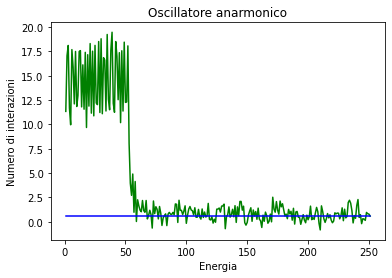

Caso 35
Sono stati impiegati 162.44668316841125 secondi
Il risultato del VQE è: 1.1775815874950015


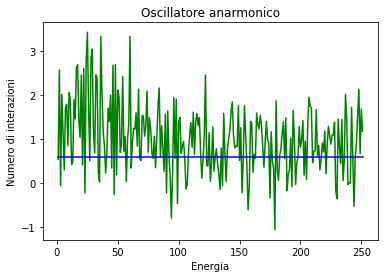

Caso 36
Sono stati impiegati 164.1035463809967 secondi
Il risultato del VQE è: -0.11276843591599892


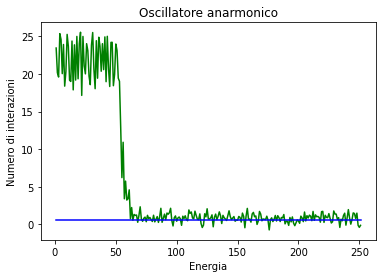

Caso 37
Sono stati impiegati 163.324609041214 secondi
Il risultato del VQE è: 0.8225577794689978


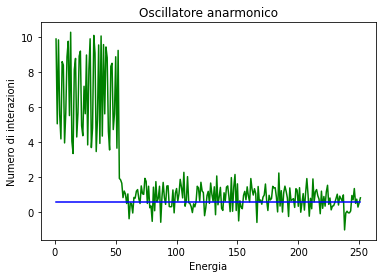

Caso 38
Sono stati impiegati 162.01985120773315 secondi
Il risultato del VQE è: 1.4528424936119992


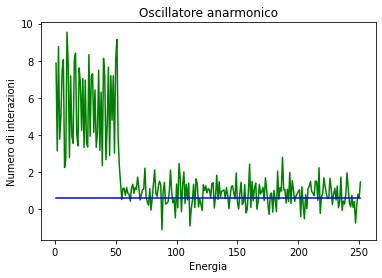

Caso 39
Sono stati impiegati 162.22252559661865 secondi
Il risultato del VQE è: 0.003315432276997529


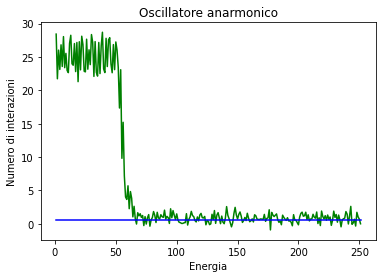

Caso 40
Sono stati impiegati 165.7210648059845 secondi
Il risultato del VQE è: 1.0015925147160027


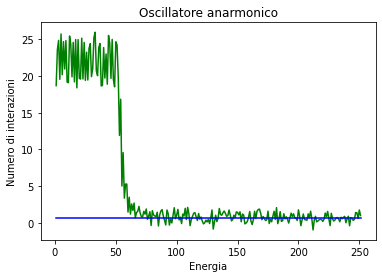

Caso 41
Sono stati impiegati 163.30405831336975 secondi
Il risultato del VQE è: 0.546265180127992


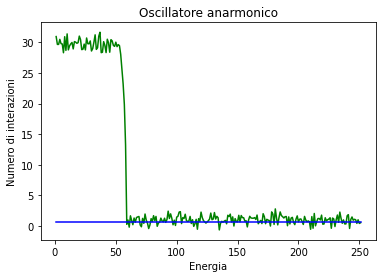

Caso 42
Sono stati impiegati 164.38671922683716 secondi
Il risultato del VQE è: 1.4943859692509962


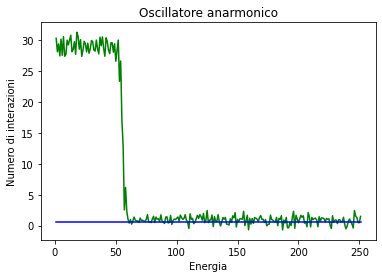

Caso 43
Sono stati impiegati 166.04283571243286 secondi
Il risultato del VQE è: 0.8312750622159986


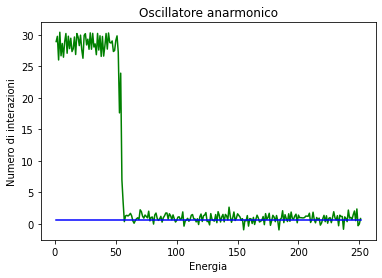

Caso 44
Sono stati impiegati 162.29744243621826 secondi
Il risultato del VQE è: 0.9247801682570028


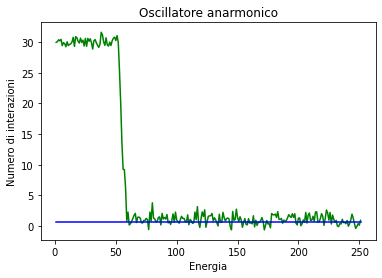

Caso 45
Sono stati impiegati 165.2529764175415 secondi
Il risultato del VQE è: 1.6436117839239965


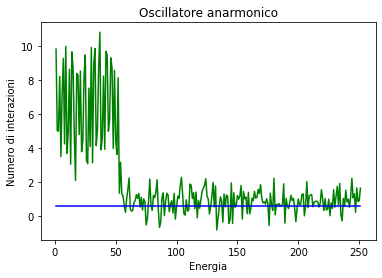

Caso 46
Sono stati impiegati 165.83067798614502 secondi
Il risultato del VQE è: 1.0187216685359903


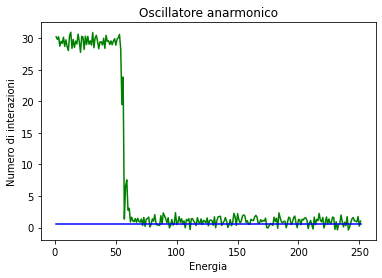

Caso 47
Sono stati impiegati 169.1270830631256 secondi
Il risultato del VQE è: 2.058834053080996


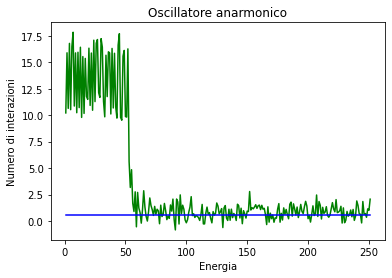

Caso 48
Sono stati impiegati 164.66733860969543 secondi
Il risultato del VQE è: 1.097332202708006


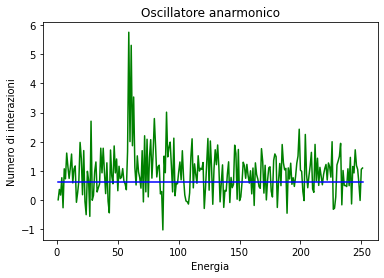

Caso 49
Sono stati impiegati 176.78256797790527 secondi
Il risultato del VQE è: 0.6934443509960015


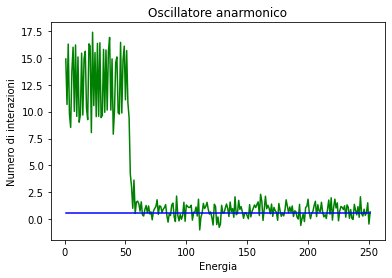

Caso 50
Sono stati impiegati 171.28956127166748 secondi
Il risultato del VQE è: 0.1605738413479914


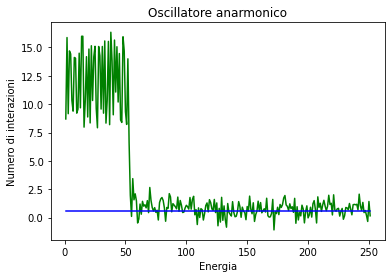

Caso 51
Sono stati impiegati 168.81323528289795 secondi
Il risultato del VQE è: 0.8875092240280056


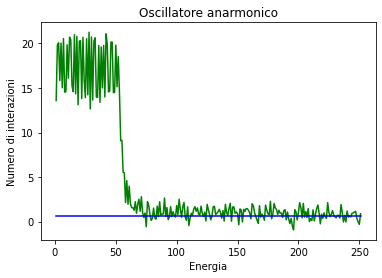

Caso 52
Sono stati impiegati 162.10750126838684 secondi
Il risultato del VQE è: 0.45997986926799117


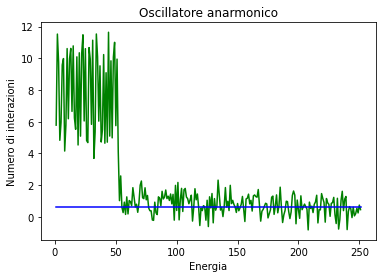

Caso 53
Sono stati impiegati 160.57326889038086 secondi
Il risultato del VQE è: 1.1779383148839901


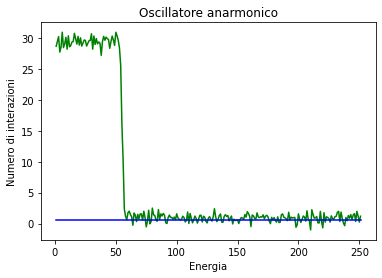

Caso 54
Sono stati impiegati 169.3818085193634 secondi
Il risultato del VQE è: 1.6759324870979961


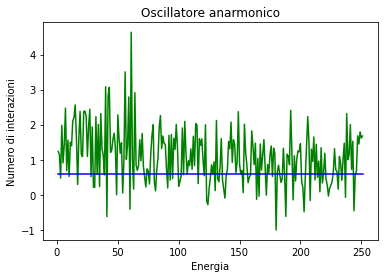

Caso 55
Sono stati impiegati 164.35684061050415 secondi
Il risultato del VQE è: 1.1438004064159937


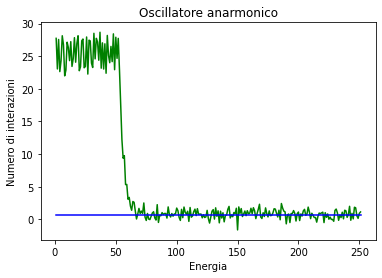

Caso 56
Sono stati impiegati 163.92127299308777 secondi
Il risultato del VQE è: 0.4652337799799946


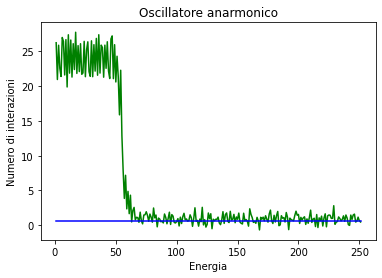

Caso 57
Sono stati impiegati 163.81769347190857 secondi
Il risultato del VQE è: 0.23901462787800096


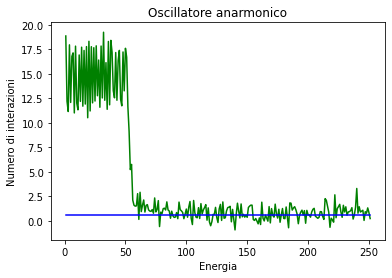

Caso 58
Sono stati impiegati 165.07662320137024 secondi
Il risultato del VQE è: 0.9255427180440103


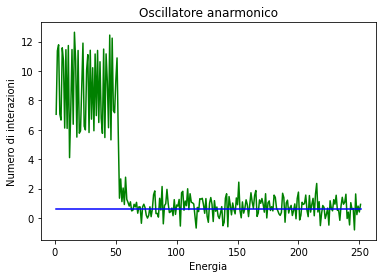

Caso 59
Sono stati impiegati 165.69652700424194 secondi
Il risultato del VQE è: 1.588788429752995


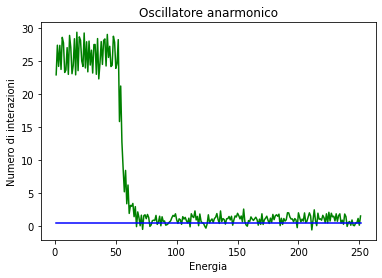

Caso 60
Sono stati impiegati 164.77870178222656 secondi
Il risultato del VQE è: 1.6570002454119943


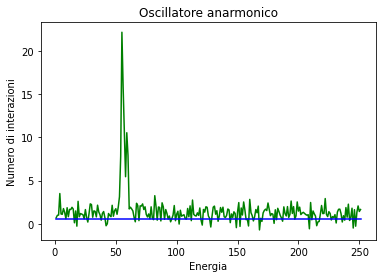

Caso 61
Sono stati impiegati 163.70734858512878 secondi
Il risultato del VQE è: 1.230607244518008


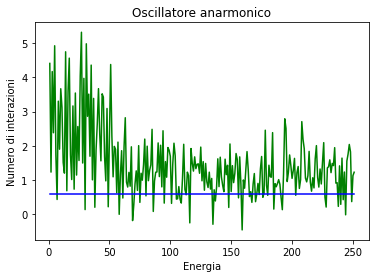

Caso 62
Sono stati impiegati 164.46150374412537 secondi
Il risultato del VQE è: 1.5340471222369987


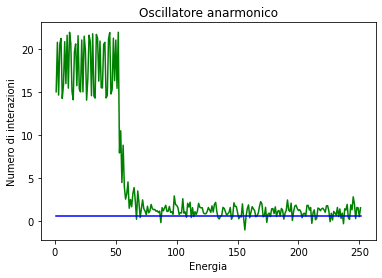

Caso 63
Sono stati impiegati 163.08895301818848 secondi
Il risultato del VQE è: 1.7493540016590035


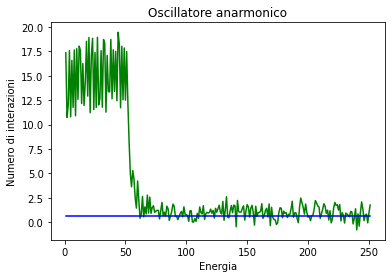

Caso 64
Sono stati impiegati 163.13480949401855 secondi
Il risultato del VQE è: 1.7442005589270118


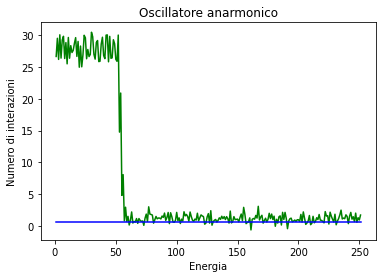

Caso 65
Sono stati impiegati 165.38611578941345 secondi
Il risultato del VQE è: 1.5304544566360019


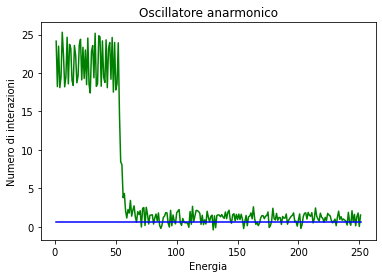

Caso 66
Sono stati impiegati 166.06074380874634 secondi
Il risultato del VQE è: 0.8683829066989861


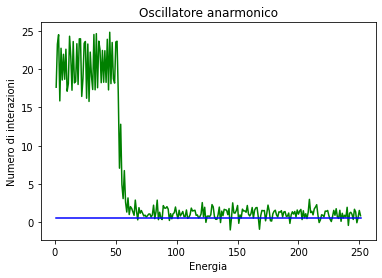

Caso 67
Sono stati impiegati 174.2931888103485 secondi
Il risultato del VQE è: 1.3221959218990003


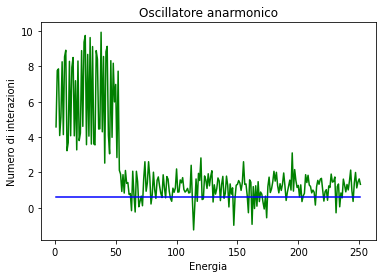

Caso 68
Sono stati impiegati 189.46795415878296 secondi
Il risultato del VQE è: 1.3872398149950067


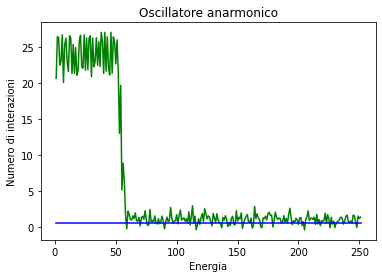

Caso 69
Sono stati impiegati 197.4295072555542 secondi
Il risultato del VQE è: 0.9714900624469884


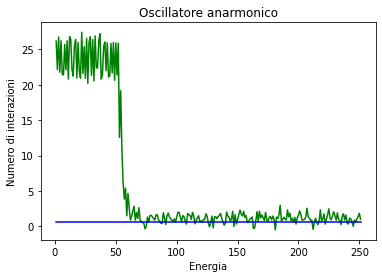

Caso 70
Sono stati impiegati 179.22654938697815 secondi
Il risultato del VQE è: 1.2563896894720024


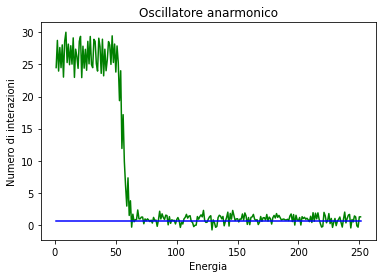

Caso 71
Sono stati impiegati 169.94400310516357 secondi
Il risultato del VQE è: 0.827751415887004


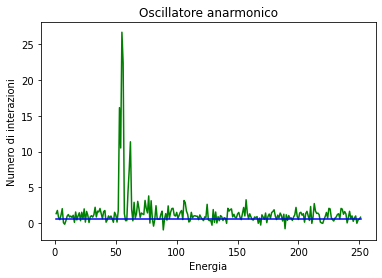

Caso 72
Sono stati impiegati 170.38631296157837 secondi
Il risultato del VQE è: -0.18263074131199866


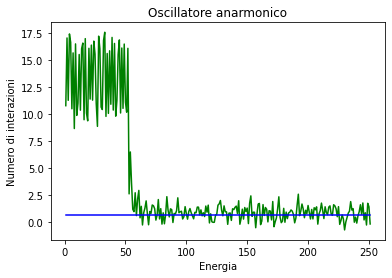

Caso 73
Sono stati impiegati 161.0003206729889 secondi
Il risultato del VQE è: 0.8815928261640052


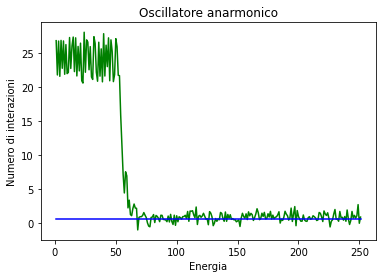

Caso 74
Sono stati impiegati 161.19846057891846 secondi
Il risultato del VQE è: 0.8037950418999977


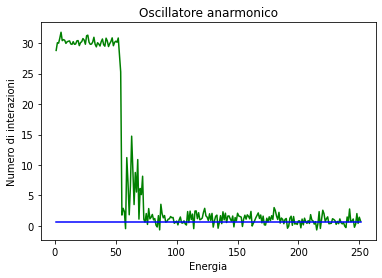

Caso 75
Sono stati impiegati 162.6347050666809 secondi
Il risultato del VQE è: 0.7197702558020082


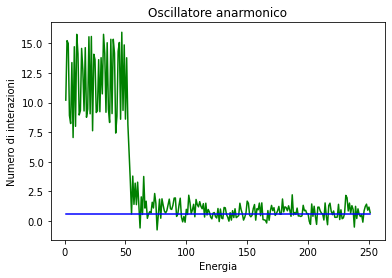

Caso 76
Sono stati impiegati 162.57791709899902 secondi
Il risultato del VQE è: 1.4646661302370034


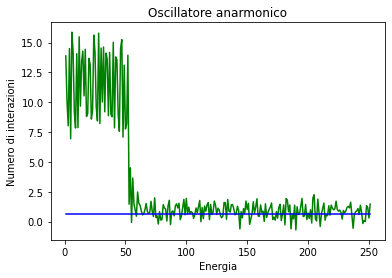

Caso 77
Sono stati impiegati 159.9331521987915 secondi
Il risultato del VQE è: 1.276459560494996


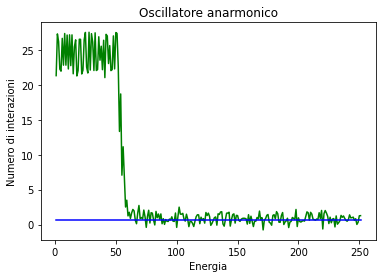

Caso 78
Sono stati impiegati 165.35272979736328 secondi
Il risultato del VQE è: 0.6540267497760078


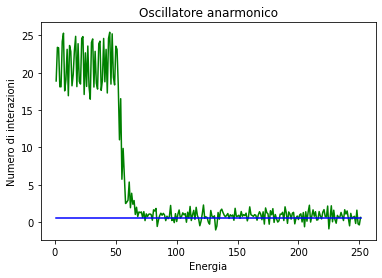

Caso 79
Sono stati impiegati 170.42227578163147 secondi
Il risultato del VQE è: 0.7693708298050052


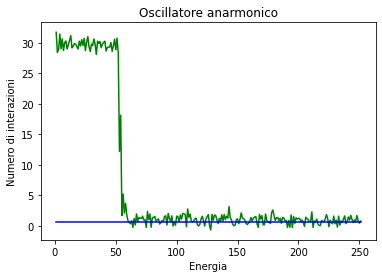

Caso 80
Sono stati impiegati 163.69709134101868 secondi
Il risultato del VQE è: 0.37438551669899783


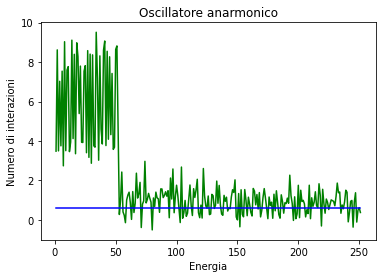

Caso 81
Sono stati impiegati 163.31489419937134 secondi
Il risultato del VQE è: 1.1867281312679927


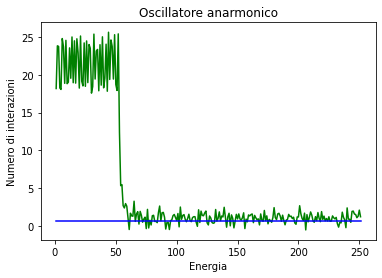

Caso 82
Sono stati impiegati 165.28215503692627 secondi
Il risultato del VQE è: 1.9166578727339931


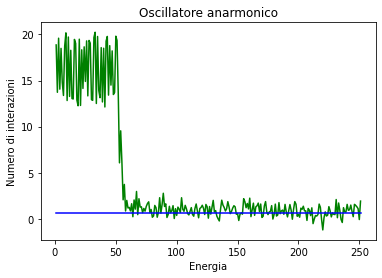

Caso 83
Sono stati impiegati 165.82075786590576 secondi
Il risultato del VQE è: 0.3183519904019979


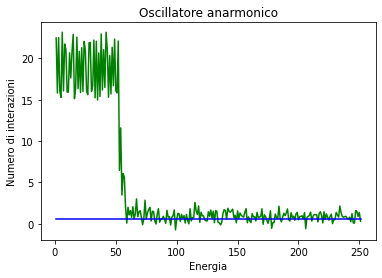

Caso 84
Sono stati impiegati 160.31255793571472 secondi
Il risultato del VQE è: 0.671630619684008


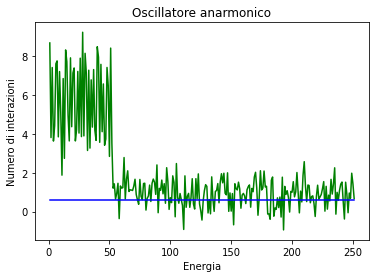

Caso 85
Sono stati impiegati 161.5173897743225 secondi
Il risultato del VQE è: 0.16363218661699136


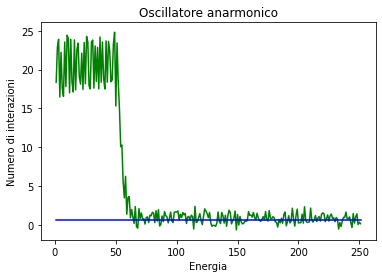

Caso 86
Sono stati impiegati 164.40691804885864 secondi
Il risultato del VQE è: 1.3460071301699945


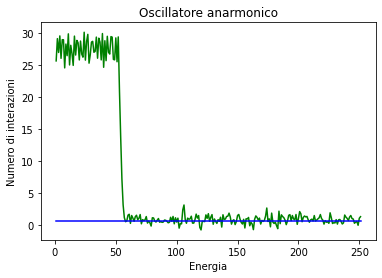

Caso 87
Sono stati impiegati 163.31272411346436 secondi
Il risultato del VQE è: 0.8867021778049983


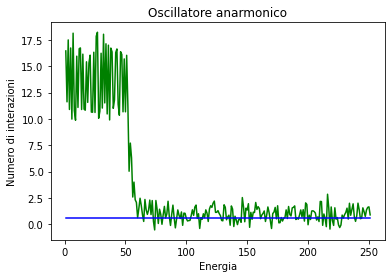

Caso 88
Sono stati impiegati 180.17667293548584 secondi
Il risultato del VQE è: 0.7025847055870026


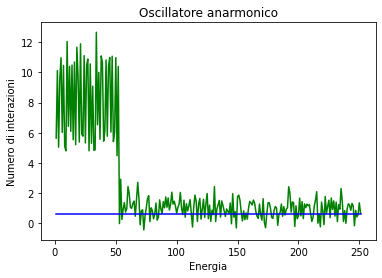

Caso 89
Sono stati impiegati 163.92459630966187 secondi
Il risultato del VQE è: 0.9500031989430038


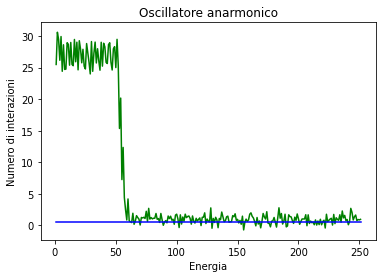

Caso 90
Sono stati impiegati 169.2903928756714 secondi
Il risultato del VQE è: 1.2252202317889942


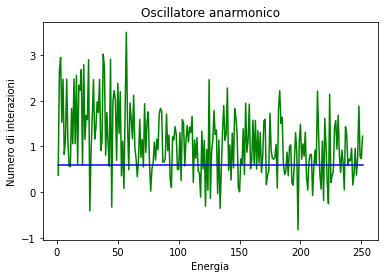

Caso 91
Sono stati impiegati 167.02634143829346 secondi
Il risultato del VQE è: -0.9125010881549982


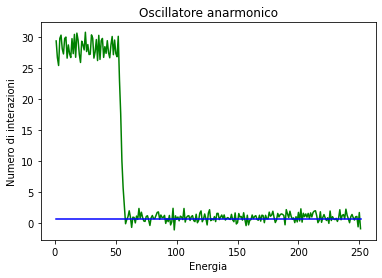

Caso 92
Sono stati impiegati 167.2945625782013 secondi
Il risultato del VQE è: 2.0218401714540004


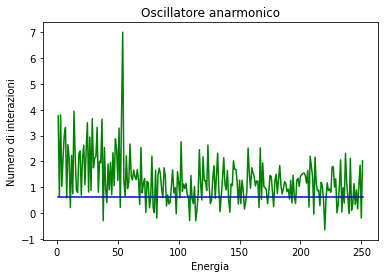

Caso 93
Sono stati impiegati 166.34344506263733 secondi
Il risultato del VQE è: 0.30142755409599326


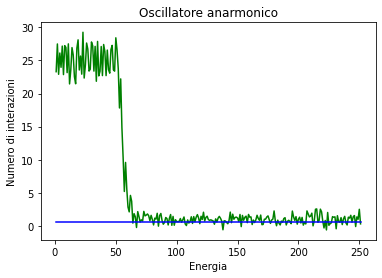

Caso 94
Sono stati impiegati 166.2629199028015 secondi
Il risultato del VQE è: 0.7873884954450068


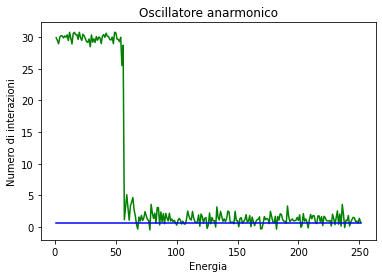

Caso 95
Sono stati impiegati 166.69504046440125 secondi
Il risultato del VQE è: 1.263920320027999


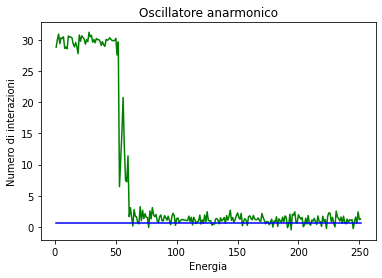

Caso 96
Sono stati impiegati 161.9214825630188 secondi
Il risultato del VQE è: 0.9979921226220022


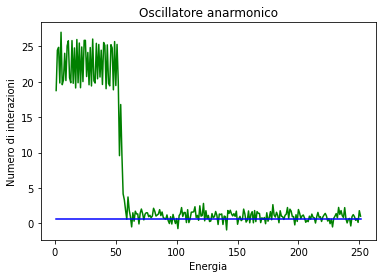

Caso 97
Sono stati impiegati 164.90233206748962 secondi
Il risultato del VQE è: 1.5713682037519994


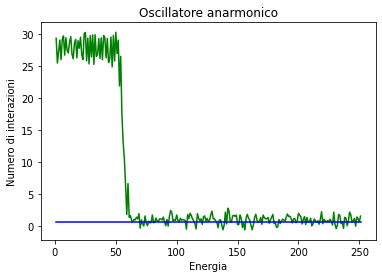

Caso 98
Sono stati impiegati 163.21773886680603 secondi
Il risultato del VQE è: 1.551129251359999


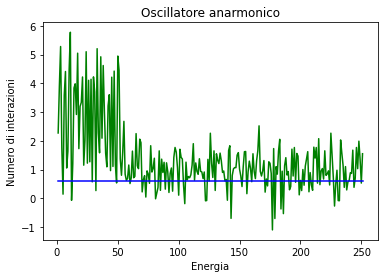

Caso 99
Sono stati impiegati 161.0453977584839 secondi
Il risultato del VQE è: 0.8911835620489956


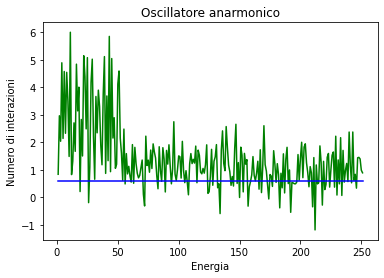

In [34]:
for i in range (1, 100):
    start_time = time.time()
    counts = []
    values = []
    parameter = []
    standard = []
    vqe = VQE(qc, 
              optimizer = SPSA(maxiter=100),
              quantum_instance = quantum_instance,
              gradient=gradient,
              callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H_anar)
    circuit = vqe.expectation
    Minimo_vqe.append(np.real(result.optimal_value))

    #Printo il tempo impiegato
    print("Caso", i)
    print("Sono stati impiegati %s secondi" % (time.time() - start_time))
    print("Il risultato del VQE è:", Minimo_vqe[i])
    
    n = len(counts)
    vero=[]
    for i in range (0,n):
        vero.append(ref_value)
    plt.plot(counts, 
             values, 
             color="green", 
             linestyle="solid")
    plt.plot(counts, 
             vero, 
             color="blue", 
             linestyle="solid")
    plt.title("Oscillatore anarmonico")
    plt.xlabel("Energia")
    plt.ylabel("Numero di interazioni")
    plt.show()
    plt.close('all')


In [35]:
Ris_vqe = np.mean(Minimo_vqe)
Err_vqe = np.std(Minimo_vqe)
print('Il risultato della Vqe è: ',Ris_vqe,"±",Err_vqe)

Il risultato della Vqe è:  0.9014905861444297 ± 0.5852631247647908


In [36]:
minimo_Vqe = []
valori_scartati = []
for i in range(0,100):
    if Minimo_vqe[i]>4*Err_vqe:
        valori_scartati.append(Minimo_vqe[i])
    else:
        minimo_Vqe.append(Minimo_vqe[i])
Ris_vqe = np.mean(minimo_Vqe)
Err_vqe = np.std(minimo_Vqe)
print(valori_scartati)
print('Il risultato della Vqe è: ',Ris_vqe,"±",Err_vqe)

[]
Il risultato della Vqe è:  0.9014905861444297 ± 0.5852631247647908


In [ ]:
risultati_con_20_reps_e_errore_n_1 = 1.269550527989526 ± 1.207770802689084
risultati_con_100_reps_e_errore_non_lavorato_n_2 = 1.3695009185856997 ± 1.8323145981090208
risultati_con_100_reps_e_errore_lavorato_n_2 = 1.1157597552709688 ± 1.1366616215140997
numero_valori_scartati_caso_sopra = 3
risultati_con_100_reps_e_errore_lavorato_n_1_dubbio_su_presenza_errore = 0.7250327966607791 ± 0.6350977189287791
numero_valori_scartati_caso_sopra = 0
risultati_con_100_reps_e_errore_lavorato_n_1 = 0.9014905861444297 ± 0.5852631247647908
numero_valori_scartati_caso_sopra = 0